In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from tqdm import tqdm
import matplotlib.pyplot as plt


class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(1, 320)  
        self.out = nn.Linear(320, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [6]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = torch.sum(torch.abs(inl.weight.data[i])).item()
        outg = torch.sum(torch.abs(oul.weight.data[:,i])).item()

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul



In [7]:
def neuralBalance(inl, oul, order=1):
    prev = torch.linalg.norm(inl.weight, dim=1, ord=order)
    out = torch.linalg.norm(oul.weight, dim = 0, ord=order)

    opt = torch.sqrt(out/prev)

    inl.weight.data = inl.weight*opt.unsqueeze(1)
    oul.weight.data = oul.weight/opt

In [8]:
X = torch.linspace(0, 4 * np.pi, 50).unsqueeze(-1)  
Y = torch.sin(X)  
X = X.to('cuda')
Y = Y.to('cuda')

model = model.to('cuda')
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad() 
    outputs = model(X)  
    loss = criterion(outputs, Y) 

    loss.backward() 
    optimizer.step() 
    
    if epoch%50 == 0:
        for i in range(len(lay)):
            if i > 0 and i <= len(lay)-1:
                neuronalNeuralBalance(lay[i-1][1], lay[i][1])

        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


Linear
Linear
Epoch 0/2000, Loss: 5.3774614334106445
Epoch 50/2000, Loss: 0.36856353282928467
Epoch 100/2000, Loss: 0.24643096327781677
Epoch 150/2000, Loss: 0.20999881625175476
Epoch 200/2000, Loss: 0.1846429854631424
Epoch 250/2000, Loss: 0.16220755875110626
Epoch 300/2000, Loss: 0.14123669266700745
Epoch 350/2000, Loss: 0.1227494403719902
Epoch 400/2000, Loss: 0.10792698711156845
Epoch 450/2000, Loss: 0.09629413485527039
Epoch 500/2000, Loss: 0.08737415075302124
Epoch 550/2000, Loss: 0.08120821416378021
Epoch 600/2000, Loss: 0.0772579088807106
Epoch 650/2000, Loss: 0.07367774099111557
Epoch 700/2000, Loss: 0.07197097688913345
Epoch 750/2000, Loss: 0.0692821592092514
Epoch 800/2000, Loss: 0.06755753606557846
Epoch 850/2000, Loss: 0.06591586023569107
Epoch 900/2000, Loss: 0.06415262818336487
Epoch 950/2000, Loss: 0.06256084889173508
Epoch 1000/2000, Loss: 0.06110202521085739
Epoch 1050/2000, Loss: 0.059554558247327805
Epoch 1100/2000, Loss: 0.057946156710386276
Epoch 1150/2000, Loss: 

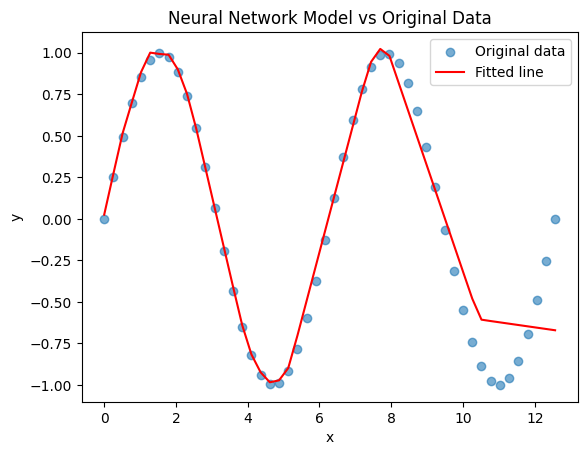

In [9]:
with torch.no_grad():
    predicted = model(X).cpu().detach().data.numpy()

X = X.cpu().detach().data.numpy()
Y = Y.cpu().detach().data.numpy()

plt.scatter(X, Y, label='Original data', alpha=0.6)
plt.plot(X, predicted, label='Fitted line', color='red')
plt.legend()
plt.title('Neural Network Model vs Original Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

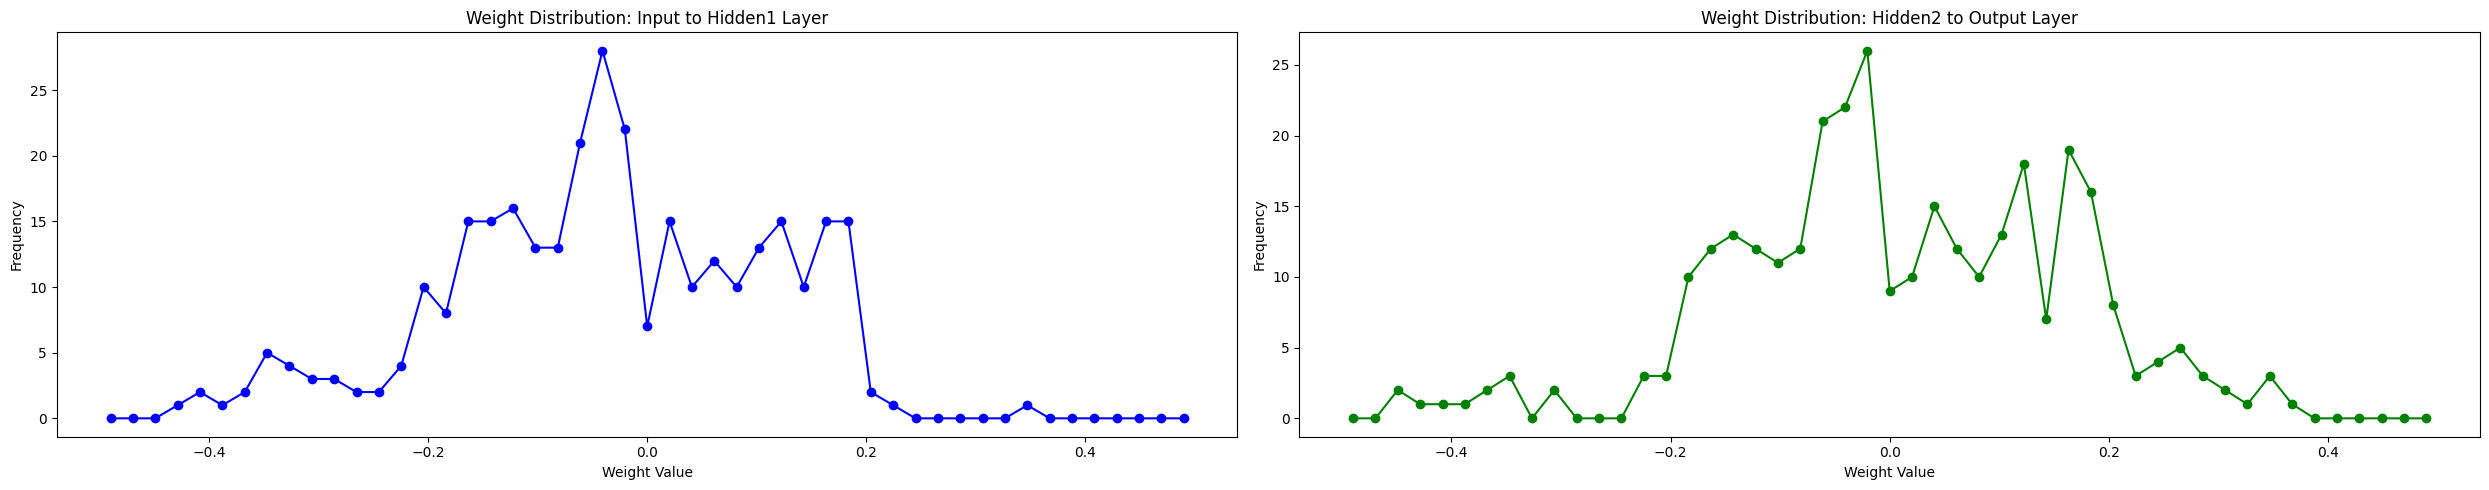

In [10]:
fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 2, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [11]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.1):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 314
Number of non-zero weights greater than 0.01 in layer 3: 312
